## Supervised Learning
## Performance comparison of supervised learning algorithms on Census data

## Getting Started

In this project, several supervised algorithms were employed to accurately model individuals' income using data collected from the 1994 U.S. Census. The best candidate algorithm from preliminary results will be further optimized to best model the data. The goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [60]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Display the first record
data.head(5)

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


In [6]:
data.groupby('income').count()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
income,,,,,,,,,,,,,
<=50K,34014,34014,34014,34014,34014,34014,34014,34014,34014,34014,34014,34014,34014
>50K,11208,11208,11208,11208,11208,11208,11208,11208,11208,11208,11208,11208,11208


### Implementation: Data Exploration


In [7]:
# TODO: Total number of records
n_records = data.shape[0]

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = data[data['income']== '>50K'].shape[0]

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = data[data['income']== '<=50K'].shape[0]

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = (n_greater_50k/(n_greater_50k+n_at_most_50k))*100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

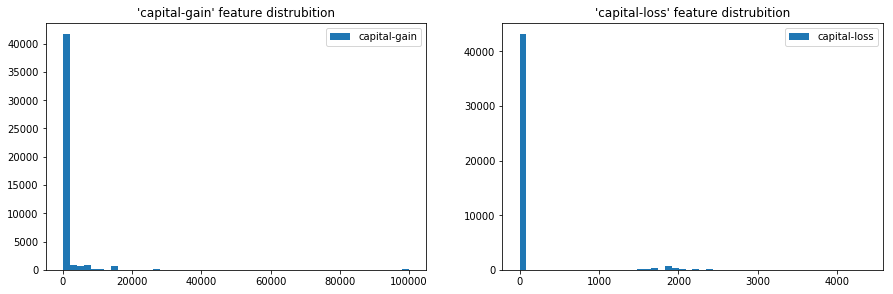

In [19]:
# Visualize skewed continuous features of original data
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.hist([data['capital-gain']], bins=50,label=['capital-gain'])  # arguments are passed to np.histogram
plt.title("'capital-gain' feature distrubition")
plt.legend()

plt.subplot(222)
plt.hist([data['capital-loss']], bins=50,label=['capital-loss'])  # arguments are passed to np.histogram
plt.title("'capital-loss' feature distrubition")
plt.legend()

plt.show()

In [20]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)


For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

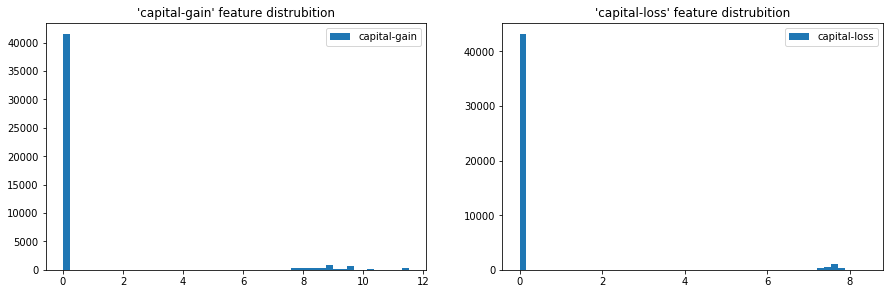

In [21]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize skewed continuous features of original data
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.hist([features_log_transformed['capital-gain']], bins=50,label=['capital-gain'])  # arguments are passed to np.histogram
plt.title("'capital-gain' feature distrubition")
plt.legend()

plt.subplot(222)
plt.hist([features_log_transformed['capital-loss']], bins=50,label=['capital-loss'])  # arguments are passed to np.histogram
plt.title("'capital-loss' feature distrubition")
plt.legend()

plt.show()

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.


In [22]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively.

In [23]:
# TODO: One-hot encode the 'features_raw' data using pandas.get_dummies()
features_final = pd.DataFrame(index = features_raw.index)

for col, objCol in features_raw.iteritems():
    if objCol.dtype == object:
        objCol = pd.get_dummies(objCol)
    features_final = features_final.join(objCol)


# TODO: Encode the 'income_raw' data to numerical values
income = income_raw.replace(["<=50K",">50K"],[0,1])

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
print (encoded)

103 total features after one-hot encoding.
['age', ' Federal-gov', ' Local-gov', ' Private', ' Self-emp-inc', ' Self-emp-not-inc', ' State-gov', ' Without-pay', ' 10th', ' 11th', ' 12th', ' 1st-4th', ' 5th-6th', ' 7th-8th', ' 9th', ' Assoc-acdm', ' Assoc-voc', ' Bachelors', ' Doctorate', ' HS-grad', ' Masters', ' Preschool', ' Prof-school', ' Some-college', 'education-num', ' Divorced', ' Married-AF-spouse', ' Married-civ-spouse', ' Married-spouse-absent', ' Never-married', ' Separated', ' Widowed', ' Adm-clerical', ' Armed-Forces', ' Craft-repair', ' Exec-managerial', ' Farming-fishing', ' Handlers-cleaners', ' Machine-op-inspct', ' Other-service', ' Priv-house-serv', ' Prof-specialty', ' Protective-serv', ' Sales', ' Tech-support', ' Transport-moving', ' Husband', ' Not-in-family', ' Other-relative', ' Own-child', ' Unmarried', ' Wife', ' Amer-Indian-Eskimo', ' Asian-Pac-Islander', ' Black', ' Other', ' White', ' Female', ' Male', 'capital-gain', 'capital-loss', 'hours-per-week', ' C

In [24]:
features_final.head()

,age,Federal-gov,Local-gov,Private,Self-emp-inc,Self-emp-not-inc,State-gov,Without-pay,10th,11th,...,Portugal,Puerto-Rico,Scotland,South,Taiwan,Thailand,Trinadad&Tobago,United-States,Vietnam,Yugoslavia
0,0.301370,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.452055,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.287671,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.493151,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,0.150685,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
income.shape[0]

45222

In [26]:
features_final.shape[0]

45222

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [27]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


/Users/sm649f/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. The performance of these algorithms is benchmarked against the Naive Predictor

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. 

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? 

** Please note ** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.



* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [28]:
pred = np.ones(income.shape[0])
pred

array([ 1.,  1.,  1., ...,  1.,  1.,  1.])

In [29]:
np.array(income)

array([0, 0, 0, ..., 0, 0, 1])

In [30]:
'''
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
predVal = np.ones(income.shape[0])
trueVal = np.array(income)
# TODO: Calculate accuracy, precision and recall
accuracy = accuracy_score(predVal,trueVal)
recall = recall_score(y_true=trueVal,y_pred=predVal)
precision = precision_score(y_true=trueVal,y_pred=predVal)

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
beta = 0.5
fscore = (1+beta**2)*(precision*recall)/(beta**2*precision+recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that we choose to evaluate**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (AdaBoost, Random Forest, Gradient Boosting)
- Stochastic Gradient Descent Classifier (SGDC)
- Logistic Regression

**Answer: **

1. Gaussian Naive Bayes (GaussianNB)

    - Sex Clasification & Document Classification
    - Extremely fast way to create simple model by assuming thatdata is described by a Gaussian distribution with no covariance between dimensions  
    - Classification is only as good as the assumption. So Gaussian naive Bayes often may not produce very good results
    - GaussianNB works well with catogorical data, given the majority of this data is catogorical, GaussianNB is a good fit.
    
2. Decision Trees

    - Decision trees are commonly used in operations research, specifically in decision analysis, to help identify a strategy most likely to reach a goal 
    - Decision trees are extremely intuitive ways to classify or label objects; The binary splitting makes this extremely efficient: in a well-constructed tree 
    - Decision Trees can easily overfit. This can be negated by validation methods and pruning, but this is a grey are
    - Decision Trees works well with binary data, therefore a good fit for our problem
    
3. AdaBoost

    - One of the popular use for AdaBoost is Face Detection
    - Extremely fast way to create simple model by assuming thatdata is described by a Gaussian distribution with no covariance between dimensions  
    - Classification is only as good as the assumption. So Gaussian naive Bayes often may not produce very good results
    - GaussianNB works well with catogorical data, given the majority of this data is catogorical, GaussianNB is a good fit.

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model, it's important that we create a training and predicting pipeline that allows for quick and effective training of  models using various sizes of training data and perform predictions on the testing data. 


In [31]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300],predictions_train,beta=0.5)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test,predictions_test,beta=0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, the following implemented:
- Import the  supervised learning models we've discussed in the previous section.
- Initialize the seven models and store them in `'clf_1'`, `'clf_1'`, and `'clf_3'` and so on ..
  - Employed the default settings for each model — we will tune one specific model in a later section.


In [68]:
# TODO: Import the seven supervised learning models from sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import NearestNeighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

# TODO: Initialize the seven models
clf_1 = RandomForestClassifier()
clf_2 = GaussianNB()
clf_3 = AdaBoostClassifier()
clf_4 = DecisionTreeClassifier()
clf_5 = GradientBoostingClassifier()
clf_6 = SGDClassifier()
clf_7 = LogisticRegression()

# TODO: Calculate the number of samples for 100% of the training data
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = int(X_train.shape[0])
# Collect results on the learners
results = {}
for clf in [clf_1, clf_2, clf_3,  clf_6, clf_7, clf_8, clf_9]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)


RandomForestClassifier trained on 36177 samples.
GaussianNB trained on 36177 samples.
AdaBoostClassifier trained on 36177 samples.
DecisionTreeClassifier trained on 36177 samples.
GradientBoostingClassifier trained on 36177 samples.
SGDClassifier trained on 36177 samples.


/Users/sm649f/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


LogisticRegression trained on 36177 samples.


In [71]:
results

{'AdaBoostClassifier': {0: {'acc_test': 0.85760088446655613,
   'acc_train': 0.84999999999999998,
   'f_test': 0.72455089820359275,
   'f_train': 0.71153846153846156,
   'pred_time': 0.054148197174072266,
   'train_time': 1.342634916305542}},
 'DecisionTreeClassifier': {0: {'acc_test': 0.81846323935876175,
   'acc_train': 0.96999999999999997,
   'f_test': 0.62772571216479545,
   'f_train': 0.96385542168674709,
   'pred_time': 0.004535675048828125,
   'train_time': 0.3803272247314453}},
 'GaussianNB': {0: {'acc_test': 0.59767827529021555,
   'acc_train': 0.59333333333333338,
   'f_test': 0.42089895957560558,
   'f_train': 0.41249999999999998,
   'pred_time': 0.036353111267089844,
   'train_time': 0.11406421661376953}},
 'GradientBoostingClassifier': {0: {'acc_test': 0.86301824212271971,
   'acc_train': 0.85666666666666669,
   'f_test': 0.7395338561802719,
   'f_train': 0.73412698412698407,
   'pred_time': 0.02517986297607422,
   'train_time': 8.519897937774658}},
 'LogisticRegression': 

----
## Improving Results
In this final section, we will choose from the seven supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 


Based on the evaluation from above, It seems clear that Descison Trees is the best oprtion. It performed well (as shown by both accuracy and F1 score) on both the training and testing set comparitely. Decison Tree is espically good on catogorical data and therefore is very suitable for charity dataset.


### Fine tuning Decusion Tree using Grid Search

In [72]:
import warnings
warnings.filterwarnings('always')  # "error", "ignore", "always", "default", "module" or "once"

In [73]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV

# TODO: Initialize the classifier
clf = DecisionTreeClassifier(random_state=0)

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {'splitter':['best','random'],'min_samples_split':[2,4,6,8,10],'max_depth' :[5,10,20,30,40,50]}# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, param_grid = parameters,scoring=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

/Users/sm649f/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Unoptimized model
------
Accuracy score on testing data: 0.8176
F-score on testing data: 0.6259

Optimized Model
------
Final accuracy score on the testing data: 0.8555
Final F-score on the testing data: 0.7198


Final Model Evaluation

* Optimized model's accuracy and F-score on the testing data are 0.73 and 0.86 respectively
* These score much better than the unoptimized model
* These scores are very much higher than the naive predection [Accuracy score: 0.2478, F-score: 0.2917]

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |   0.8176          |      0.8555     |
| F-score        |   0.6259          |      0.6259     |


----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.


In [78]:
X_train.columns

Index(['age', ' Federal-gov', ' Local-gov', ' Private', ' Self-emp-inc',
       ' Self-emp-not-inc', ' State-gov', ' Without-pay', ' 10th', ' 11th',
       ...
       ' Portugal', ' Puerto-Rico', ' Scotland', ' South', ' Taiwan',
       ' Thailand', ' Trinadad&Tobago', ' United-States', ' Vietnam',
       ' Yugoslavia'],
      dtype='object', length=103)

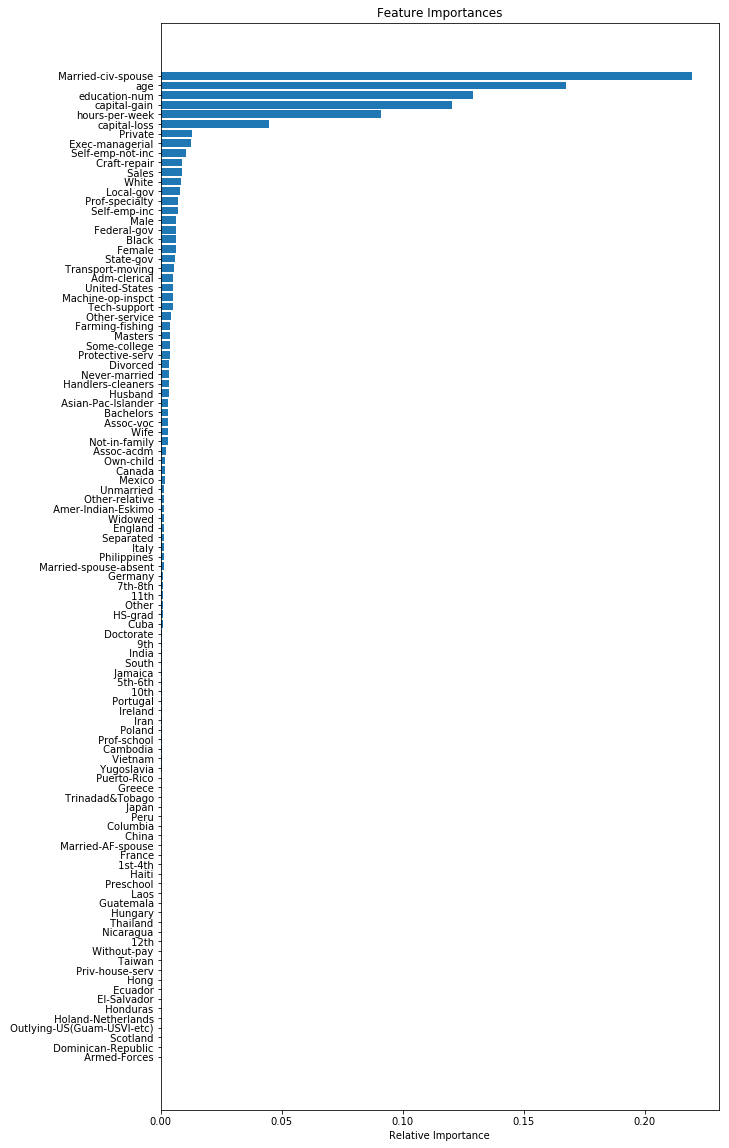

In [85]:
# TODO: Import a supervised learning model that has 'feature_importances_'
clf = DecisionTreeClassifier(random_state=0)

# TODO: Train the supervised model on the training set using .fit(X_train, y_train)
model = clf.fit(X_train,y_train)

# TODO: Extract the feature importances using .feature_importances_ 
importances = clf.feature_importances_

# Plot
importances = clf.feature_importances_
features  = X_train.columns
indices = np.argsort(importances)
plt.figure(figsize=(10,20))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. 

In [86]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8555
F-score on testing data: 0.7198

Final Model trained on reduced data
------
Accuracy on testing data: 0.8457
F-score on testing data: 0.6940



The final model's F-score and accuracy on the reduced data are lower than the model including all the features. It went down from 0.8555 to 0.8457 for the accuracy and 0.7198 to 0.6940 for F-score. I'd recommending using the full data for trainging